<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Define-some-utility-functions" data-toc-modified-id="Define-some-utility-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define some utility functions</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Build-model" data-toc-modified-id="Build-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Create-data-loaders" data-toc-modified-id="Create-data-loaders-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create data loaders</a></span></li><li><span><a href="#Train-model-with-Spatial-Transformer" data-toc-modified-id="Train-model-with-Spatial-Transformer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train model with Spatial Transformer</a></span></li><li><span><a href="#Train-model-without-Spatial-Transformer" data-toc-modified-id="Train-model-without-Spatial-Transformer-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train model without Spatial Transformer</a></span></li><li><span><a href="#Visualize-Spatial-Transformer's-output" data-toc-modified-id="Visualize-Spatial-Transformer's-output-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualize Spatial Transformer's output</a></span></li><li><span><a href="#Visualize-learning-progress-of-STN" data-toc-modified-id="Visualize-learning-progress-of-STN-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Visualize learning progress of STN</a></span></li></ul></div>

# Import libraries

In [1]:
import io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Define some utility functions

In [2]:
def visualize_image(image):
    plt.imshow(image.squeeze(), cmap="binary")
    plt.show()

In [3]:
def visualize_images(images, labels, offset=0):
    figure = plt.figure(figsize=(10, 10))
    for i in range(offset, offset+25):
        ax = plt.subplot(5, 5, i-offset+1)
        plt.imshow(images[i].squeeze(), cmap="binary")
        plt.title(labels[i])
        plt.axis("off")
    return figure

In [4]:
# Source: https://www.tensorflow.org/tensorboard/image_summaries
def plot_to_image(figure):
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

# Load data

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
x_test.shape

(10000, 28, 28)

In [8]:
def preprocess(images):
    norm_images = images.astype("float32") / 255.0
    return np.reshape(norm_images, (-1, 28, 28, 1))

# Normalize images
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Build model

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from stn.transformer import get_pixel_value, affine_grid_generator, bilinear_sampler

In [10]:
class LocalisationNet(tf.keras.layers.Layer):
    def __init__(self):
        super(LocalisationNet, self).__init__()
        self.conv_1 = Conv2D(8, kernel_size=7, activation="relu", kernel_initializer="he_normal")
        self.maxpool_1 = MaxPool2D(strides=2)
        self.conv_2 = Conv2D(10, kernel_size=5, activation="relu", kernel_initializer="he_normal")
        self.maxpool_2 = MaxPool2D(strides=2)
        
    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.maxpool_1(x)
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        return x

In [11]:
# Regressor for the 3 * 2 transformation parameters
class AffineDense(tf.keras.layers.Layer):
    def __init__(self):
        super(AffineDense, self).__init__()
        self.dense_1 = Dense(32, activation="relu", kernel_initializer="he_normal")
        identity_transform_params = tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0])
        self.dense_2 = Dense(3 * 2, kernel_initializer="zeros", bias_initializer=identity_transform_params)
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        theta = self.dense_2(x)
        return theta

In [12]:
class SpatialTransformer(tf.keras.layers.Layer):
    def __init__(self):
        super(SpatialTransformer, self).__init__()
        self.loc_net = LocalisationNet()
        self.affine_dense = AffineDense()
        
    def call(self, inputs):
        x = self.loc_net(inputs)
        x = tf.reshape(x, (-1, 10 * 3 * 3))
        theta = self.affine_dense(x)
        theta = tf.reshape(theta, (-1, 2, 3))
        
        grid = affine_grid_generator(28, 28, theta)
        xs = grid[:, 0, :, :]
        ys = grid[:, 1, :, :]
        return bilinear_sampler(inputs, xs, ys)

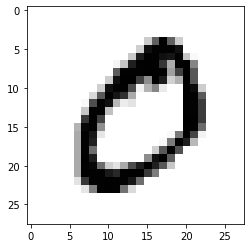

In [13]:
# Test with an image
visualize_image(x_train[1])

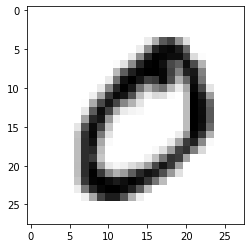

In [14]:
# It should look almost the same after the transformation because the STN module hasn't learned anything
transformed_x = SpatialTransformer()(np.expand_dims(x_train[1], 0))
visualize_image(transformed_x.numpy())

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.optimizers import Adam

In [16]:
IMG_SIZE = 28
VAL_SIZE = 2000
BATCH_SIZE = 32
EPOCHS = 100

In [17]:
def get_model(use_stn=True):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    if use_stn:
        x = SpatialTransformer()(inputs)
    else:
        x = inputs
    conv_1 = Conv2D(10, (5, 5), activation="relu", kernel_initializer="he_normal")(x)
    maxpooling_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Conv2D(20, (5, 5), activation="relu", kernel_initializer="he_normal")(maxpooling_1)
    dropout_1 = SpatialDropout2D(0.5)(conv_2)
    maxpooling_2 = MaxPooling2D(pool_size=(2, 2))(dropout_1)
    x = tf.reshape(maxpooling_2, (-1, 320))
    dense_1 = Dense(50, activation="relu", kernel_initializer="he_normal")(x)
    dropout_2 = Dropout(0.5)(dense_1)
    dense_2 = Dense(10, activation="softmax")(dropout_2)
    
    model = Model(inputs=inputs, outputs=dense_2)
    return model

# Create data loaders

In [18]:
x_val, y_val = x_train[:VAL_SIZE], y_train[:VAL_SIZE]
new_x_train, new_y_train = x_train[VAL_SIZE:], y_train[VAL_SIZE:]

train_ds = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# Train model with Spatial Transformer

In [19]:
stn = get_model()
stn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
spatial_transformer_1 (Spati (None, 28, 28, 1)         5520      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 8, 8, 20)          0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 20)         

In [20]:
# Log how the transformation params learned by Spatial Transformer evolve over time.
st_module = tf.keras.Model(stn.input, stn.layers[-10].output)
file_writer_cm = tf.summary.create_file_writer("logs/stn_progress")

def log_progression(epoch, logs):
    transformed_tests = st_module(x_test[:25])
    figure = visualize_images(transformed_tests.numpy(), y_test[:25])
    progress_image = plot_to_image(figure)
    with file_writer_cm.as_default():
        tf.summary.image("Progression", progress_image, step=epoch)

In [21]:
# Callbacks
es_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
progress_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_progression)

In [22]:
stn.compile(optimizer = Adam(), loss = "sparse_categorical_crossentropy", metrics = ["acc"])
stn.fit(train_ds, validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[es_callback, reduce_lr, progress_callback])

Epoch 1/100
1813/1813 [==============================] - 15s 8ms/step - loss: 0.4807 - acc: 0.8519 - val_loss: 0.1105 - val_acc: 0.9675
Epoch 2/100
1813/1813 [==============================] - 12s 7ms/step - loss: 0.1918 - acc: 0.9472 - val_loss: 0.0759 - val_acc: 0.9790
Epoch 3/100
1813/1813 [==============================] - 12s 7ms/step - loss: 0.1494 - acc: 0.9577 - val_loss: 0.0642 - val_acc: 0.9820
Epoch 4/100
1813/1813 [==============================] - 14s 7ms/step - loss: 0.1302 - acc: 0.9635 - val_loss: 0.0610 - val_acc: 0.9835
Epoch 5/100
1813/1813 [==============================] - 13s 7ms/step - loss: 0.1161 - acc: 0.9669 - val_loss: 0.0585 - val_acc: 0.9835
Epoch 6/100
1813/1813 [==============================] - 13s 7ms/step - loss: 0.1096 - acc: 0.9692 - val_loss: 0.0504 - val_acc: 0.9870
Epoch 7/100
1813/1813 [==============================] - 14s 8ms/step - loss: 0.0996 - acc: 0.9717 - val_loss: 0.0455 - val_acc: 0.9855
Epoch 8/100
1813/1813 [=========================

In [23]:
_, test_acc = stn.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0346 - acc: 0.9904
Test accuracy: 99.04%


# Train model without Spatial Transformer

In [24]:
model = get_model(use_stn=False)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 8, 8, 20)          0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 320)]            

In [25]:
model.compile(optimizer = Adam(), loss = "sparse_categorical_crossentropy", metrics = ["acc"])
model.fit(train_ds, validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[es_callback, reduce_lr])

Epoch 1/100
1813/1813 [==============================] - 7s 4ms/step - loss: 0.5548 - acc: 0.8216 - val_loss: 0.1114 - val_acc: 0.9680
Epoch 2/100
1813/1813 [==============================] - 7s 4ms/step - loss: 0.2425 - acc: 0.9295 - val_loss: 0.0878 - val_acc: 0.9740
Epoch 3/100
1813/1813 [==============================] - 7s 4ms/step - loss: 0.2016 - acc: 0.9414 - val_loss: 0.0855 - val_acc: 0.9780
Epoch 4/100
1813/1813 [==============================] - 7s 4ms/step - loss: 0.1773 - acc: 0.9482 - val_loss: 0.0791 - val_acc: 0.9815
Epoch 5/100
1813/1813 [==============================] - 7s 4ms/step - loss: 0.1666 - acc: 0.9523 - val_loss: 0.0725 - val_acc: 0.9825
Epoch 6/100
1813/1813 [==============================] - 7s 4ms/step - loss: 0.1549 - acc: 0.9543 - val_loss: 0.0711 - val_acc: 0.9830
Epoch 7/100
1813/1813 [==============================] - 7s 4ms/step - loss: 0.1481 - acc: 0.9565 - val_loss: 0.0743 - val_acc: 0.9815
Epoch 8/100
1813/1813 [==============================] 

In [26]:
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0368 - acc: 0.9890
Test accuracy: 98.90%


# Visualize Spatial Transformer's output

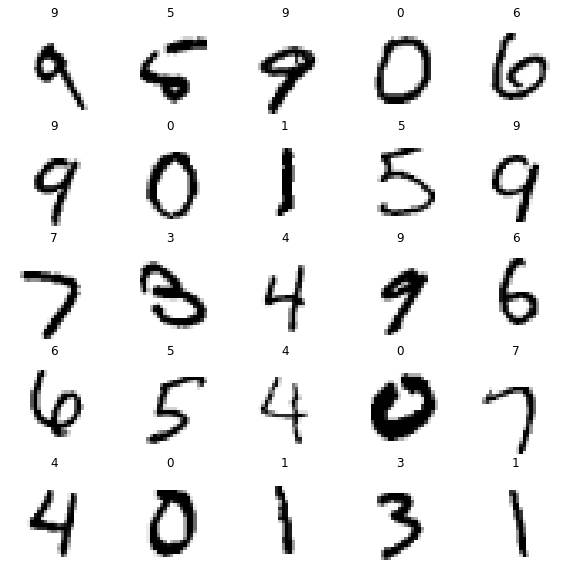

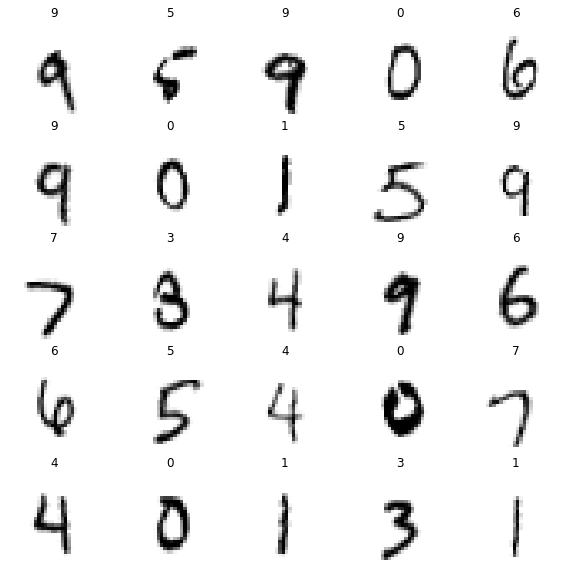

In [27]:
TEST_OFFSET = 7

# Original images
_ = visualize_images(x_test, y_test, TEST_OFFSET)

# Transformed images
transformed_x = st_module(x_test[TEST_OFFSET:])
_ = visualize_images(transformed_x.numpy(), y_test[TEST_OFFSET:])

# Visualize learning progress of STN

In [55]:
%load_ext tensorboard
%tensorboard --logdir "logs/stn_progress"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to start 'D:/Python/Anaconda3/envs/py3.7/Lib/site-
packages/tensorboard' (set by the `TENSORBOARD_BINARY` environment
variable): [WinError 5] Access is denied

In [51]:
!tar cf logs.tar.gz logs

tar: Couldn't open logs/stn_progress/events.out.tfevents.1620240945.DESKTOP-H25NGAB.24696.1112.v2: Permission denied
tar: Error exit delayed from previous errors.
